In [1]:
pip install -q tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00


In [2]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" #for openai pretrained weights
        ]

for p in pkgs:
  print(f"{p} version: {version(p)}")

matplotlib version: 3.7.1
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.4.0+cu121
tensorflow version: 2.17.0


# Evaluating Generative text models


Using gpt to generate text

In [3]:
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [4]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


In [5]:
GPT_CONFIG_124M ={
    "vocab_size" : 50257,
    "context_length" : 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); #disable dropuout during inference

In [6]:
def text_to_token_ids(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) #add batch dimension
  return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
  flat = token_ids.squeeze(0) #remove batch dimension
  return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text: \n",token_ids_to_text(token_ids,tokenizer))

Output text: 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


# Calculating text generation loss: cross-entropy and perplexity

In [7]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [8]:
#input to the model > 3 tokens each> each token is 50257 dim vector > softmax for tensor

with torch.no_grad():
  logits = model(inputs)

probas = torch.softmax(logits,dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [9]:
#argmax to convert probabilities to token id of highest prob score
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print("Token ids:\n",token_ids)

Token ids:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [10]:
#decode to find what it predicted
print(f"Targets batch 1: {token_ids_to_text(targets[0],tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [11]:
#model isn't trained yet
#how far from correct predictions
text_idx =0
target_probas_1 = probas[text_idx,[0,1,2],targets[text_idx]]
print("text 1:", target_probas_1)

text_idx=1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print('text 2: ',target_probas_2)

text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
text 2:  tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [12]:
#maximize all values > bring them close to prob of 1
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [13]:
#average log prob
avg_log_probas = torch.mean(log_probas)
print("average log prob:", avg_log_probas)

average log prob: tensor(-10.7940)


In [14]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

#called loss
#already implemented in pytorch

tensor(10.7940)


In [15]:
#shape of logits and targets
print("logits shape:", logits.shape)
print('target shape:', targets.shape)

logits shape: torch.Size([2, 3, 50257])
target shape: torch.Size([2, 3])


In [16]:
#flatten for pytorch cross entropy
#flatten across batch dimension
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

print(logits_flat.shape)
print(targets_flat.shape)

torch.Size([6, 50257])
torch.Size([6])


In [17]:
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.7940)


In [18]:
#perplexity similar to cross entropy
#it is exponential of cross entropy loss
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


# Calculalting training and validation set losses

In [19]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"


if not os.path.exists(file_path):
  with urllib.request.urlopen(url) as response:
    text_data = response.read().decode('utf-8')
  with open(file_path,'w',encoding='utf-8') as file:
    file.write(text_data)
else:
  with open(file_path,'r',encoding='utf-8') as file:
    text_data = file.read()

In [20]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [21]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print('total charcters in text data',total_characters)
print('total tokens in text data',total_tokens)

total charcters in text data 20479
total tokens in text data 5145


In [22]:
#divide dataset for training and validation
#here max length is 6 but we usually max length is equal to context len of the model that is used
#from previous chapters import create_dataloader_v1

In [23]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [24]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [25]:
#sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
  print("Not enough tokens for the trainig loader."
  "Try to lower the `GPT_CONFIG_124M['context_length']` or"
  "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
  print("Not enough tokens for the validation loader."
  "Try to lower the `GPT_CONFIG_124M['context_length']` or"
  "decrease the `training_ratio`")

In [26]:
#check if data loaded correctly
print("Train Loader:")
for x,y in train_loader:
  print(x.shape,y.shape)

print("Validation Loader")
for x, y in val_loader:
  print(x.shape,y.shape)

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation Loader
torch.Size([2, 256]) torch.Size([2, 256])


In [27]:
#additional check for token sized
train_tokens = 0
for input_batch, target_batch in train_loader:
  train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
  val_tokens += input_batch.numel()


print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [28]:
# fun to calculate cross entropy loss of given batch
# fun to compute loss for user specified batches

def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
  return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
#disable gradient tracking for efficiency because not training yet
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader,model,device)
  val_loss = calc_loss_loader(val_loader,model,device)

print("Training loss",train_loss)
print("Validation loss",val_loss)


Training loss 10.98758347829183
Validation loss 10.98110580444336


# Trainig an LLM

In [30]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,
                       eval_freq,eval_iter,start_context,tokenizer):
  #initialize lists to track losses and tokens seen
  train_losses, val_losses,track_tokens_seen = [],[],[]
  tokens_seen, global_step = 0, -1

  #main training loop
  for epoch in range(num_epochs):
    model.train() #set model to training mode
    for input_batch,target_batch in train_loader:
      optimizer.zero_grad()  #reset loss gradients from previous batch iteration
      loss = calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward() #calculate loss gradients
      optimizer.step() #update model weights using loss gradients
      tokens_seen += input_batch.numel()
      global_step += 1


      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
             model, train_loader, val_loader, device, eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    #print sample text after each step
    generate_and_print_sample(
        model,tokenizer,device,start_context
    )
  return train_losses,val_losses,track_tokens_seen

def evaluate_model(model,train_loader,val_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

  model.train()
  return train_loss,val_loss

def generate_and_print_sample(model,tokenizer,device,start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context,tokenizer).to(device)

  with torch.no_grad():
    token_ids = generate_text_simple(
        model=model,idx=encoded,
        max_new_tokens=50,context_size=context_size
    )
    decoded_text = token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n"," "))
    model.train()

In [31]:
#train llm
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)

num_epochs =10
train_losses,val_losses,tokens_seen = train_model_simple(
    model,train_loader,val_loader,optimizer,device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

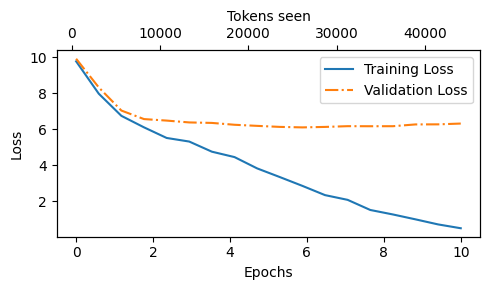

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen,tokens_seen,train_losses,val_losses):
  fig, ax1 = plt.subplots(figsize=(5,3))

  #plot training and validation losses against epochs
  ax1.plot(epochs_seen,train_losses,label="Training Loss")
  ax1.plot(epochs_seen,val_losses,linestyle='-.',label="Validation Loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  #second x axis for tokens seen
  ax2 = ax1.twiny() #share same y axis
  ax2.plot(tokens_seen,train_losses,alpha=0)
  ax2.set_xlabel("Tokens seen")

  fig.tight_layout() #adjust layout to make room
  plt.savefig("loss-plot.pdf")
  plt.show()


epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor,tokens_seen,train_losses,val_losses)

# Decoding strategies to remove randomness

In [33]:
model.to(device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens =25,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [34]:
#decoding strategies > temperature scaling, tok-k sampling
#to control randomness and diversity of generated text


In [35]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [36]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [37]:
def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas,num_samples=1).item() for i in range(1_000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i,freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")


print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [38]:
#temperature scaling
def softmax_with_temperature(logits,temperature):
  scaled_logits = logits/temperature
  return torch.softmax(scaled_logits,dim=0)

#temperature values
temperatures = [1,0.1,5] # Original, higher confidence, and lower confidence

#calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits,T) for T in temperatures]

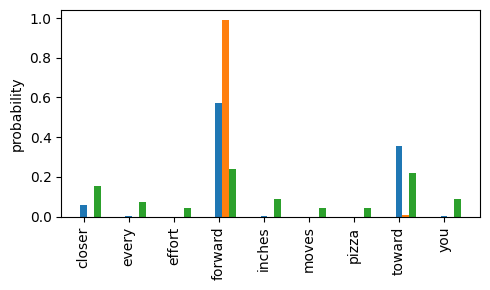

In [39]:
#plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig,ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(),rotation=90)
ax.legend

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [40]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


In [41]:
#The rescaled probabilities via temperature 5 are more uniformly distributed:
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


Top k-sampling

In [42]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits,top_k)
print('top logits:',top_logits)
print('top positions:',top_pos)

top logits: tensor([6.7500, 6.2800, 4.5100])
top positions: tensor([3, 7, 0])


In [43]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [44]:
torch_probas = torch.softmax(new_logits,dim=0)
torch_probas

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

Modifying the text generation function

In [45]:
#new generate function based on generate_text used earlier using temp scaling and top-k sampling

def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:]

  #filter logits with topk sampling
    if top_k is not None:
      #keep only top_k values
      top_logits, _ = torch.topk(logits,top_k)
      min_value = top_logits[:,-1]
      logits = torch.where(logits < min_value, torch.tensor(float("-inf")).to(logits.device), logits)
    #apply temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probs = torch.softmax(logits,dim=-1)
      idx_next = torch.multinomial(probs,num_samples=1)

    else:
      idx_next = torch.argmax(logits,dim=-1,keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx,idx_next),dim=1)

  return idx



In [46]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)


print("Output text:",token_ids_to_text(token_ids,tokenizer))

Output text: Every effort moves you know began to my surprise, a little it was the
"Ah enough


# Loading and saving model weights in pytorch

In [47]:
torch.save(model.state_dict(),"model.pth")

In [48]:
#load model weights into new gptmodel instance
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth",map_location=device,weights_only=True))
model.eval();

In [49]:
#adaptive optimizers like adam and adamW store additional parameters, save them as well
#to continue pretrainig later
torch.save(
    {
        "model_state_dict":model.state_dict(),
        "optimizer_state_dict":optimizer.state_dict()
    },
    "model_and_optimizer.pth"
)

In [50]:
checkpoint = torch.load("model_and_optimizer.pth",weights_only=True)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(),lr=0.0005,weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

# Loading pretrained weights from OpenAI

In [51]:
#openai used tensorflow

!pip install -q tensorflow tqdm

In [52]:
print(version('tensorflow'))
print(version('tqdm'))


2.17.0
4.66.5


In [53]:
# Relative import from the gpt_download.py contained in this folder
import os
import urllib.request

# import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination):
    # Send a GET request to download the file

    try:
        with urllib.request.urlopen(url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return

            # Define the block size for reading the file
            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(url)  # Extract filename from URL
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                # Open the destination file in binary write mode
                with open(destination, "wb") as file:
                    # Read the file in chunks and write to destination
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))  # Update progress bar
    except urllib.error.HTTPError:
        s = (
            f"The specified URL ({url}) is incorrect, the internet connection cannot be established,"
            "\nor the requested file is temporarily unavailable.\nPlease visit the following website"
            " for help: https://github.com/rasbt/LLMs-from-scratch/discussions/273")
        print(s)

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [54]:
settings,params = download_and_load_gpt2(model_size="124M",models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 99.4kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 614kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 144kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:58<00:00, 8.52MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.57MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 399kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 385kiB/s]


In [55]:
print("Settings:",settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [56]:
print("Parameters dictionary keys: ",params.keys())

Parameters dictionary keys:  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [57]:
print(params["wte"])
print("token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
token embedding weight tensor dimensions: (50257, 768)


In [58]:
#transfer gpt weights onto GPTModel instance
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768,"n_layers":12,"n_heads":12},
    "gpt2-medium (355M)": {"emb_dim":1024,"n_layers":24,"n_heads":16},
    "gpt2-large (774M)": {"emb_dim":1280,"n_layers":36,"n_heads":20},
    "gpt2-xl (1558M)": {"emb_dim":1600,"n_layers":48,"n_heads":25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()

NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length":1024,"qkv_bias":True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [61]:
#assign openai weights to corresponding weight tensors in gptmodel instance
def assign(left,right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")

  return torch.nn.Parameter(torch.tensor(right))

In [63]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

In [64]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
